In [189]:
import json
import numpy as np
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sn
sn.set_style("white")

In [2]:
def load_groundtruth_pred(ground_truth_filename=None, prediction_filename=None, subset='validation', verbose=False, top_k=1):
    if not ground_truth_filename:
        raise IOError('Please input a valid ground truth file.')
    if not prediction_filename:
        raise IOError('Please input a valid prediction file.')

    ap = None
    hit_at_k = None
    # Import ground truth and predictions.
    ground_truth, activity_index = _import_ground_truth(ground_truth_filename)
    prediction = _import_prediction(prediction_filename, activity_index)

    if verbose:
        print('[INIT] Loaded annotations from {} subset.'.format(subset))
        nr_gt = len(ground_truth)
        print('\tNumber of ground truth instances: {}'.format(nr_gt))
        nr_pred = len(prediction)
        print('\tNumber of predictions: {}'.format(nr_pred))
        
    return ground_truth, prediction

In [3]:
def _import_ground_truth(ground_truth_filename):
    """Reads ground truth file, checks if it is well formatted, and returns
       the ground truth instances and the activity classes.
    Parameters
    ----------
    ground_truth_filename : str
        Full path to the ground truth json file.
    Outputs
    -------
    ground_truth : df
        Data frame containing the ground truth instances.
    activity_index : dict
        Dictionary containing class index.
    """
    with open(ground_truth_filename, 'r') as fobj:
        data = json.load(fobj)
    # Checking format
    # if not all([field in data.keys() for field in self.gt_fields]):
        # raise IOError('Please input a valid ground truth file.')

    # Initialize data frame
    activity_index, cidx = {}, 0
    video_lst, label_lst = [], []
    for videoid, v in data['database'].items():
        if 'validation' != v['subset']:
            continue
        this_label = v['annotations']['label']
        if this_label not in activity_index:
            activity_index[this_label] = cidx
            cidx += 1
        video_lst.append(videoid)
        label_lst.append(activity_index[this_label])
    ground_truth = pd.DataFrame({'video-id': video_lst,
                                 'label': label_lst})
    ground_truth = ground_truth.drop_duplicates().reset_index(drop=True)
    return ground_truth, activity_index

In [4]:
def _import_prediction(prediction_filename, activity_index):
    """Reads prediction file, checks if it is well formatted, and returns
       the prediction instances.
    Parameters
    ----------
    prediction_filename : str
        Full path to the prediction json file.
    Outputs
    -------
    prediction : df
        Data frame containing the prediction instances.
    """
    with open(prediction_filename, 'r') as fobj:
        data = json.load(fobj)
    # Checking format...
    # if not all([field in data.keys() for field in self.pred_fields]):
        # raise IOError('Please input a valid prediction file.')

    # Initialize data frame
    video_lst, label_lst, score_lst = [], [], []
    for videoid, v in data['results'].items():
        for result in v:
            label = activity_index[result['label']]
            video_lst.append(videoid)
            label_lst.append(label)
            score_lst.append(result['score'])
    prediction = pd.DataFrame({'video-id': video_lst,
                               'label': label_lst,
                               'score': score_lst})
    return prediction

In [5]:
#ground_truth, prediction = load_groundtruth_pred(ground_truth_filename, prediction_filename, 'validation', True, top_k)

In [6]:
#print(ground_truth.head)

In [7]:
#print(prediction.head)

In [8]:
def evaluate(ground_truth, prediction, top_k, verbose ):
    """Evaluates a prediction file. For the detection task we measure the
    interpolated mean average precision to measure the performance of a
    method.
    """
    hit_at_k, y_pred, y_true, video_name = compute_video_hit_at_k(ground_truth, prediction, top_k)
    if verbose:
        print('[RESULTS] Performance on ActivityNet untrimmed video '
               'classification task.')
        print('\tError@{}: {}'.format(top_k, 1.0 - hit_at_k))
        print('\n')
    
    if top_k == 1 :
        conf_mtx = confusion_matrix(y_true, y_pred)
        prec_rec = classification_report(y_true, y_pred)
        print('Confusion Matrix\n')
        print(conf_mtx)
        print('\n')
        print('Other metrics')
        print(prec_rec)
    return hit_at_k

In [9]:
def compute_video_hit_at_k(ground_truth, prediction, top_k=3):
    """Compute accuracy at k prediction between ground truth and
    predictions data frames. This code is greatly inspired by evaluation
    performed in Karpathy et al. CVPR14.
    Parameters
    ----------
    ground_truth : df
        Data frame containing the ground truth instances.
        Required fields: ['video-id', 'label']
    prediction : df
        Data frame containing the prediction instances.
        Required fields: ['video-id, 'label', 'score']
    Outputs
    -------
    acc : float
        Top k accuracy score.
    """
    video_ids = np.unique(ground_truth['video-id'].values)
    avg_hits_per_vid = np.zeros(video_ids.size)
    video_name, y_true,y_pred = [],[],[]
    for i, vid in enumerate(video_ids):
        pred_idx = prediction['video-id'] == vid
        if not pred_idx.any():
            continue
        this_pred = prediction.loc[pred_idx].reset_index(drop=True)
        # Get top K predictions sorted by decreasing score.
        sort_idx = this_pred['score'].values.argsort()[::-1][:top_k]
        this_pred = this_pred.loc[sort_idx].reset_index(drop=True)
        # Get labels and compare against ground truth.
        pred_label = this_pred['label'].tolist()
        gt_idx = ground_truth['video-id'] == vid
        gt_label = ground_truth.loc[gt_idx]['label'].tolist()
        avg_hits_per_vid[i] = np.mean([1 if this_label in pred_label else 0
                                       for this_label in gt_label])
        y_pred.append(pred_label)
        y_true.append(gt_label)
        video_name.append(vid)
    return float(avg_hits_per_vid.mean()), y_pred, y_true, video_name

In [234]:
def top1_accuracy():
    ground_truth_filename = "/home/shared/workspace/Resnet3D/3D-ResNets-PyTorch/data/ntu_01.json"
    prediction_root_filename = "/home/shared/workspace/human-activity-recognition/Efficient-3DCNNs/data/results"
    fine_tune_result_dir = ['resnet_18_50_ccrop','resnet_50_50_ccrop','resnet_101_50_ccrop','resnext_101_50_ccrop',
                  'mobilenetv2_1.0x_50_ccrop', 'shufflenetv2_1.0x_50_ccrop', 'squeezenet_1.0x_50_ccrop']
    scratch_result_dir = ['resnet_18_50_full','resnet_50_50_full','resnet_101_50_full','resnext_101_50_full',
                  'mobilenetv2_1.0x_50_full', 'shufflenetv2_1.0x_50_full', 'squeezenet_1.0x_50_full', 'c3d_18_50_full']
    hit_scratch = []
    for p in scratch_result_dir:
        print("----------Showing prediction for {}-------------".format(p))
        prediction_filename = prediction_root_filename + "/" + p + "/" + "val.json"
        print(prediction_filename)
        ground_truth, prediction = load_groundtruth_pred(ground_truth_filename, prediction_filename, 'validation', True, 3)
        hit_at_k = evaluate(ground_truth, prediction, 1, True )
        hit_scratch.append(hit_at_k*100)
        
    hit_fine_tune = []
    for p in fine_tune_result_dir:
        print("----------Showing prediction for {}-------------".format(p))
        prediction_filename = prediction_root_filename + "/" + p + "/" + "val.json"
        print(prediction_filename)
        ground_truth, prediction = load_groundtruth_pred(ground_truth_filename, prediction_filename, 'validation', True, 3)
        hit_at_k = evaluate(ground_truth, prediction, 1, True )
        hit_fine_tune.append(hit_at_k*100)
        
    return hit_scratch, hit_fine_tune
    

In [235]:
hit_scratch, hit_fine_tune = top1_accuracy()

----------Showing prediction for resnet_18_50_full-------------
/home/shared/workspace/human-activity-recognition/Efficient-3DCNNs/data/results/resnet_18_50_full/val.json
[INIT] Loaded annotations from validation subset.
	Number of ground truth instances: 1707
	Number of predictions: 5121
[RESULTS] Performance on ActivityNet untrimmed video classification task.
	Error@1: 0.5307557117750439


Confusion Matrix

[[ 43   6   3  20   1  46  10  34  27]
 [  1 183   3   0   0   2   0   1   0]
 [  0   2 187   0   0   0   0   0   0]
 [  0   0   0  78   4  74  19   0  14]
 [ 34   2   0  16  12  50  11  41  24]
 [ 23   2   0  27  11  83   6  12  26]
 [ 14   0   0  42   4  91  15   2  22]
 [ 13  10   8   3   3   2   1 144   5]
 [ 32   3   0  19   4  46  10  20  56]]


Other metrics
              precision    recall  f1-score   support

           0       0.27      0.23      0.25       190
           1       0.88      0.96      0.92       190
           2       0.93      0.99      0.96       189
  

[RESULTS] Performance on ActivityNet untrimmed video classification task.
	Error@1: 0.4838898652606912


Confusion Matrix

[[ 76   0   0  29  16  19  22  19   9]
 [  8 177   0   0   0   2   0   2   1]
 [  0   2 184   0   0   0   0   3   0]
 [  7   0   0 133   3   8  22   0  16]
 [ 36   0   0  29  41  11  32  32   9]
 [ 26   0   0  54  12  27  41   1  29]
 [ 23   0   0  77   8  12  59   0  11]
 [ 18   6   2   2  13   1   5 142   0]
 [  4   1   0 114   3   9  17   0  42]]


Other metrics
              precision    recall  f1-score   support

           0       0.38      0.40      0.39       190
           1       0.95      0.93      0.94       190
           2       0.99      0.97      0.98       189
           3       0.30      0.70      0.42       189
           4       0.43      0.22      0.29       190
           5       0.30      0.14      0.19       190
           6       0.30      0.31      0.30       190
           7       0.71      0.75      0.73       189
           8       0.3

[RESULTS] Performance on ActivityNet untrimmed video classification task.
	Error@1: 0.2220269478617457


Confusion Matrix

[[128   1   0  16  20   2  12  10   1]
 [  1 188   0   0   0   0   0   1   0]
 [  0   0 189   0   0   0   0   0   0]
 [ 17   0   0 113   2  10  47   0   0]
 [ 13   0   0   9 121  23   6  18   0]
 [  7   2   0  10  32 131   8   0   0]
 [ 16   0   0  42   4  13 109   1   5]
 [ 10   0   1   1  10   1   1 164   1]
 [  0   0   0   1   0   0   4   0 185]]


Other metrics
              precision    recall  f1-score   support

           0       0.67      0.67      0.67       190
           1       0.98      0.99      0.99       190
           2       0.99      1.00      1.00       189
           3       0.59      0.60      0.59       189
           4       0.64      0.64      0.64       190
           5       0.73      0.69      0.71       190
           6       0.58      0.57      0.58       190
           7       0.85      0.87      0.86       189
           8       0.9

In [232]:
hit_scratch, hit_fine_tune = top1_accuracy()

----------Showing prediction for resnet_18_50_full-------------
/home/shared/workspace/human-activity-recognition/Efficient-3DCNNs/data/results/resnet_18_50_full/val.json
[INIT] Loaded annotations from validation subset.
	Number of ground truth instances: 1707
	Number of predictions: 5121
[RESULTS] Performance on ActivityNet untrimmed video classification task.
	Error@2: 0.36848271821909784


----------Showing prediction for resnet_50_50_full-------------
/home/shared/workspace/human-activity-recognition/Efficient-3DCNNs/data/results/resnet_50_50_full/val.json
[INIT] Loaded annotations from validation subset.
	Number of ground truth instances: 1707
	Number of predictions: 5121
[RESULTS] Performance on ActivityNet untrimmed video classification task.
	Error@2: 0.29173989455184535


----------Showing prediction for resnet_101_50_full-------------
/home/shared/workspace/human-activity-recognition/Efficient-3DCNNs/data/results/resnet_101_50_full/val.json
[INIT] Loaded annotations from vali

/home/ubuntu/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[RESULTS] Performance on ActivityNet untrimmed video classification task.
	Error@1: 0.1704745166959578


Confusion Matrix

[[146   0   0  15  13   5   7   3   1]
 [  1 189   0   0   0   0   0   0   0]
 [  0   0 189   0   0   0   0   0   0]
 [ 14   0   0 127   2   9  35   1   1]
 [  7   0   0   5 137  22   3  15   1]
 [  6   1   0   6  20 146  10   1   0]
 [  7   0   0  29   1  16 136   0   1]
 [  7   1   0   0  17   1   0 163   0]
 [  2   0   0   1   1   0   3   0 183]]


Other metrics
              precision    recall  f1-score   support

           0       0.77      0.77      0.77       190
           1       0.99      0.99      0.99       190
           2       1.00      1.00      1.00       189
           3       0.69      0.67      0.68       189
           4       0.72      0.72      0.72       190
           5       0.73      0.77      0.75       190
           6       0.70      0.72      0.71       190
           7       0.89      0.86      0.88       189
           8       0.9

In [237]:
hit_scratch[:-1]

[46.92442882249561,
 52.60691271236087,
 53.01698886936145,
 52.899824253075565,
 52.02108963093146,
 50.55653192735794,
 51.611013473930875]

In [238]:
hit_fine_tune

[71.294669009959,
 81.54657293497364,
 83.83128295254832,
 82.95254833040421,
 77.79730521382542,
 70.24018746338606,
 73.63796133567662]

In [252]:
sn.set_style("white")
def plot(hit_scratch, hit_fine_tune):
    labels = ['Resnet18', 'Resnet50', 'Resnet101', 'Resnext101', 'Mobilenetv2', 'Shufflenetv2', 'Squeezenet']

    x = np.arange(len(labels))  # the label locations
    width = 0.3  # the width of the bars

    fig, ax = plt.subplots(figsize = (13,7))
    rects1 = ax.bar(x - width/2, hit_scratch, width, label='Training from scratch')
    rects2 = ax.bar(x + width/2, hit_fine_tune, width, label='Fine-tuning on pretrained model')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Accuracy')
    ax.set_title('Difference in accuracy with pretrained models')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
#     ax.bar_label(rects1, padding=3)
#     ax.bar_label(rects2, padding=3)

    fig.tight_layout()

    plt.show()
    fig.savefig('pretrained.png')

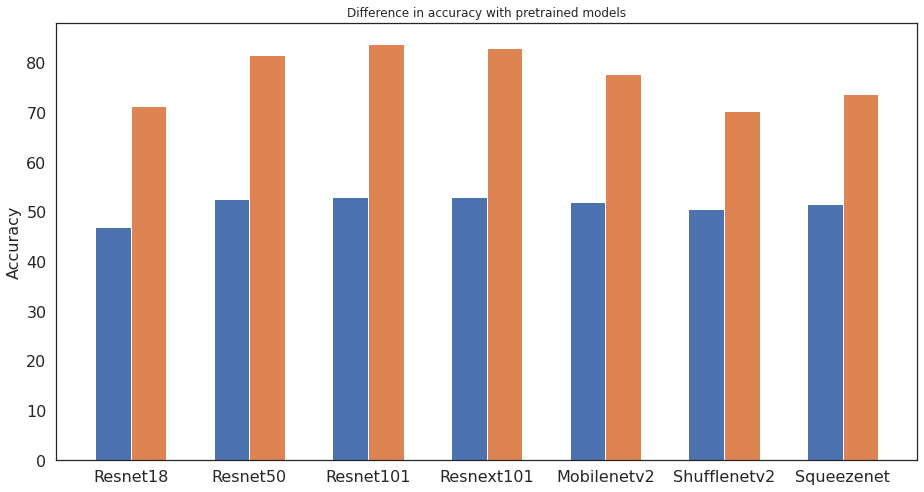

In [253]:
plot(hit_scratch[:-1], hit_fine_tune)

In [254]:
def plot_line(hit_scratch, hit_fine_tune):
    model_depth = [18, 50, 101]
    fig = plt.figure(figsize=(6,5))
    plt.plot(model_depth, hit_fine_tune[0:3], 'orange', linewidth=2)

    plt.title('Effect of model depth on accuracy')
    plt.xlabel('Model depth')
    plt.ylabel('Accuracy')
    #plt.legend(['Training from scratch', 'Fine-tuning on pre-trained models'])
    plt.show()
    fig.savefig('model_depth.png')

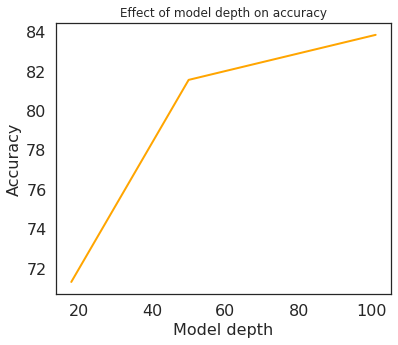

In [255]:
plot_line(hit_scratch, hit_fine_tune)

In [68]:
classname = {0: 'sneezeCough', 1: 'staggering', 2: 'fallingDown', 3: 'headache', 4: 'chestPain', 5: 'backPain', 6: 'neckPain', 7: 'nauseaVomiting', 8: 'fanSelf'}

In [153]:
def plot_conf_matrix():
    ground_truth_filename = "/home/shared/workspace/Resnet3D/3D-ResNets-PyTorch/data/ntu_01.json"
    prediction_root_filename = "/home/shared/workspace/human-activity-recognition/Efficient-3DCNNs/data/results"
    p = 'resnet_101_50_ccrop'

    prediction_filename = prediction_root_filename + "/" + p + "/" + "val.json"
    print(prediction_filename)
    ground_truth, prediction = load_groundtruth_pred(ground_truth_filename, prediction_filename, 'validation', True, 3)
    hit_at_k, y_pred, y_true, video_name = compute_video_hit_at_k(ground_truth, prediction, 1)
    conf_mtx = confusion_matrix(y_true, y_pred)
    columns = [classname[i] for i in range(9)]
    print(columns)
    df_cm = pd.DataFrame(conf_mtx, index = columns, columns = columns)
    fig = plt.figure(figsize=(32,20))
    sn.set(font_scale=2.8) # for label size
    sn.heatmap(df_cm, cmap='Oranges', annot=True, fmt="d") # font size
    plt.show()
    fig.savefig('confusion_matrix.png')



/home/shared/workspace/human-activity-recognition/Efficient-3DCNNs/data/results/resnet_101_50_ccrop/val.json
[INIT] Loaded annotations from validation subset.
	Number of ground truth instances: 1707
	Number of predictions: 5121
['sneezeCough', 'staggering', 'fallingDown', 'headache', 'chestPain', 'backPain', 'neckPain', 'nauseaVomiting', 'fanSelf']


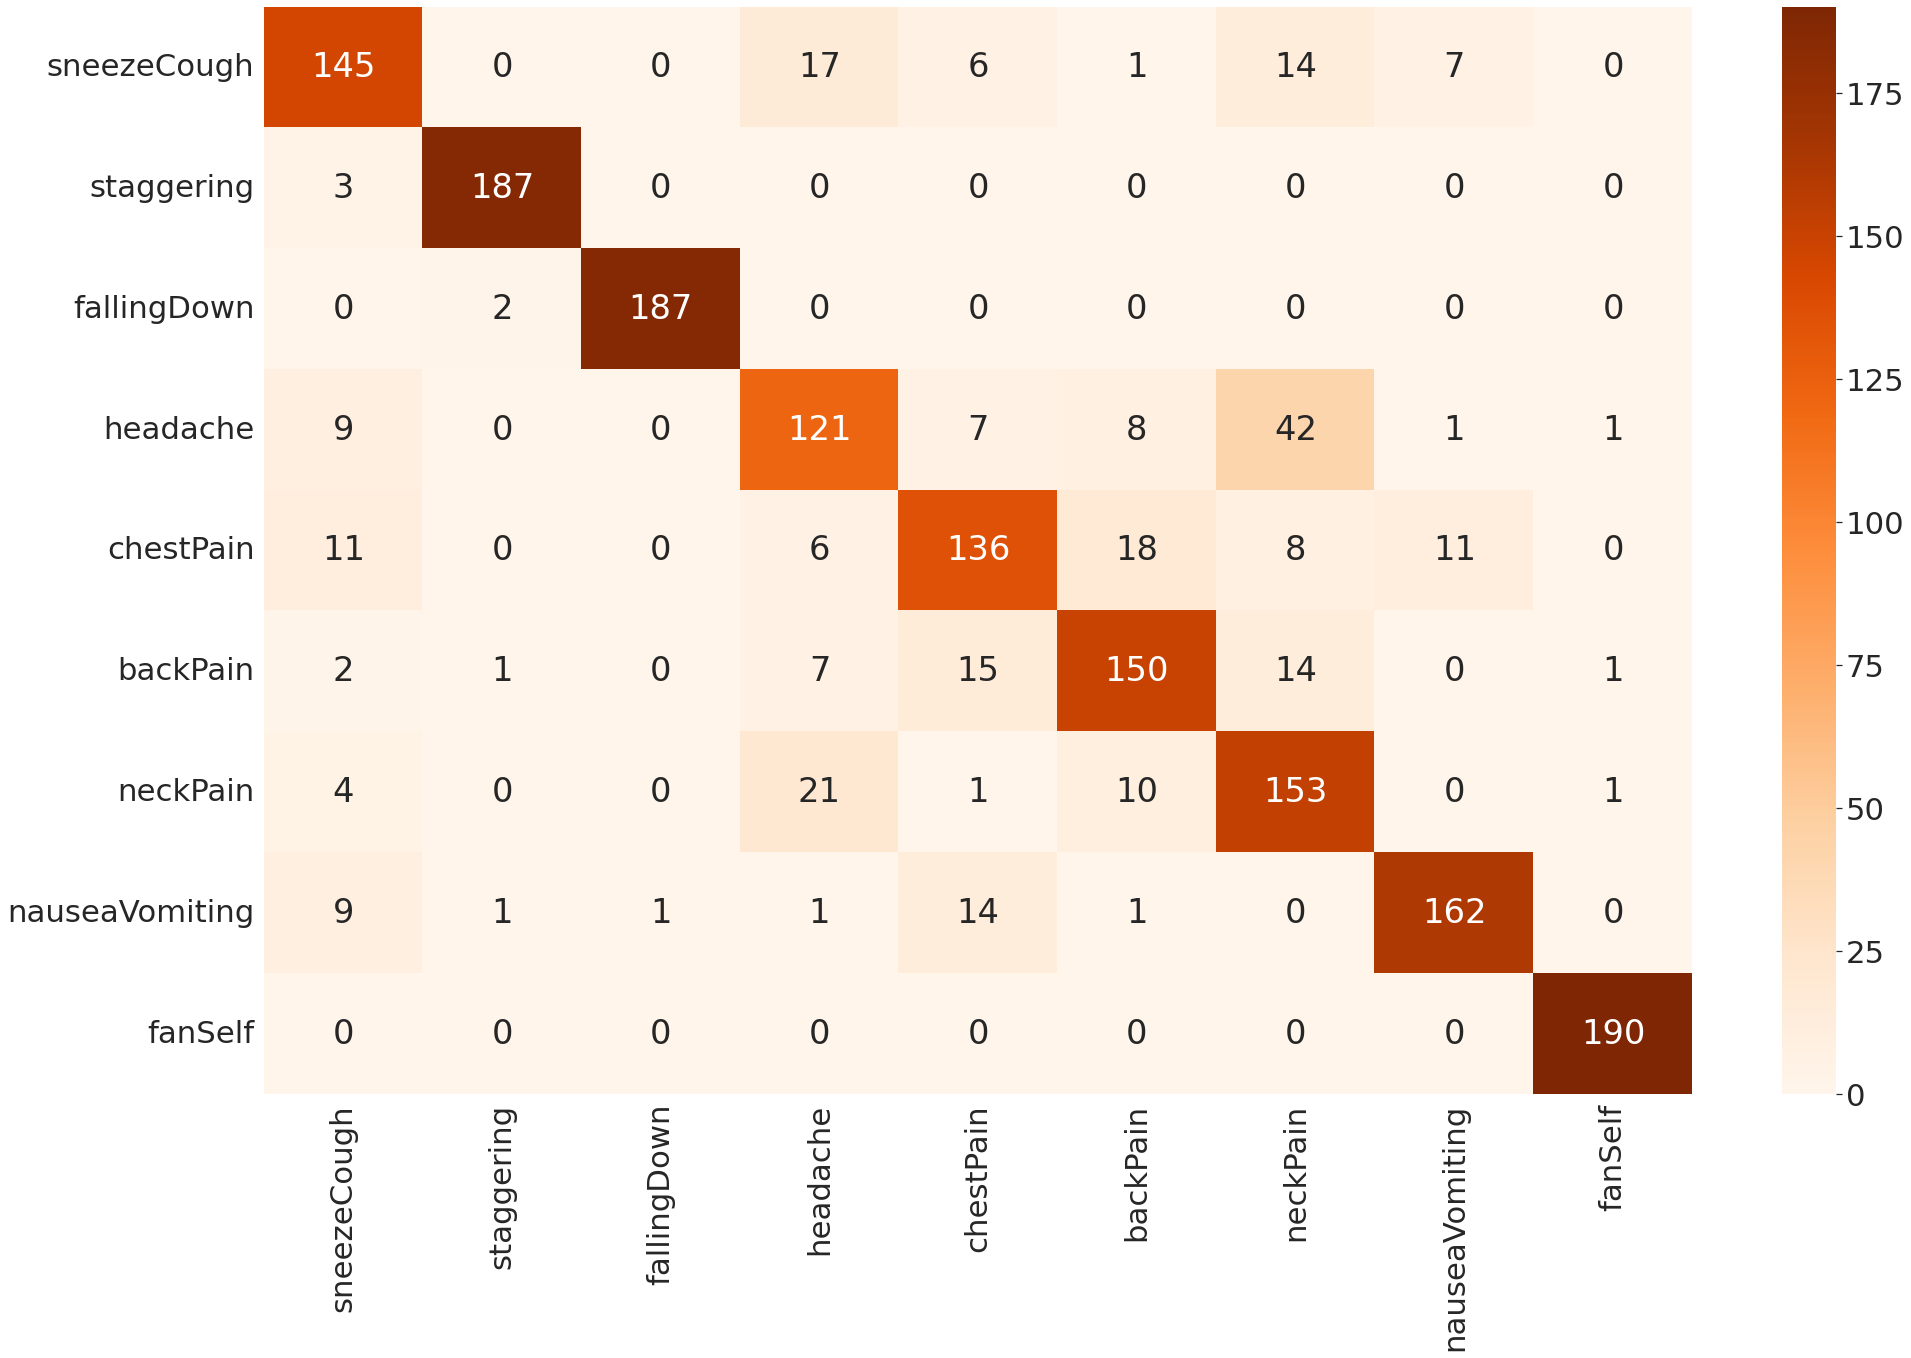

In [154]:
plot_conf_matrix()

In [260]:
import csv
epoch = []
train_loss = []
train_acc = []
learn_rate = []
with open('/home/shared/workspace/human-activity-recognition/Efficient-3DCNNs/data/results/resnext_101_50_ccrop/train.log', 'r') as f:
    reader = csv.reader(f,delimiter='\t')
    headers = next(reader) 
    for row in reader:
        epoch.append(float(row[0]))
        train_loss.append(float(row[1]))
        train_acc.append(float(row[2]))
        learn_rate.append(float(row[4]))
        
val_epoch = []
val_loss = []
val_acc = []
with open('/home/shared/workspace/human-activity-recognition/Efficient-3DCNNs/data/results/resnext_101_50_ccrop/val.log', 'r') as f:
    reader = csv.reader(f,delimiter='\t')
    headers = next(reader) 
    for row in reader:
        val_epoch.append(float(row[0]))
        val_loss.append(float(row[1]))
        val_acc.append(float(row[2]))

In [261]:
import matplotlib.pyplot as plt

SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

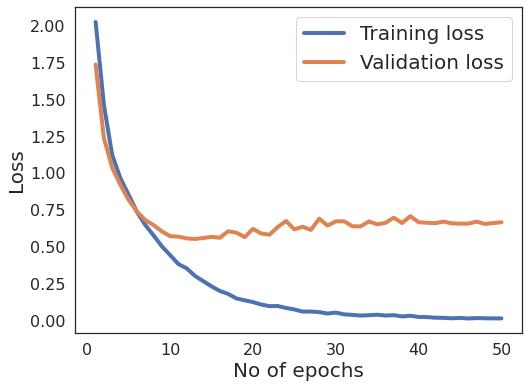

In [262]:
fig = plt.figure(figsize=(8,6))
plt.plot(epoch, train_loss, label = "Training loss", linewidth=4)
plt.plot(epoch, val_loss, label = "Validation loss", linewidth=4)
plt.legend(fontsize=20)
plt.xlabel('No of epochs', fontsize = 20)
plt.ylabel('Loss', fontsize = 20)
plt.show()
plt.grid
fig.savefig('loss.png')

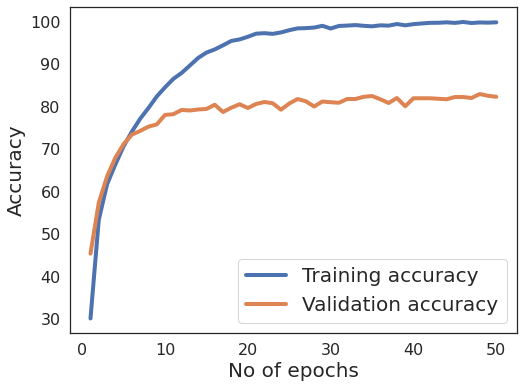

In [263]:
fig = plt.figure(figsize=(8,6))
plt.plot(epoch, train_acc, label = "Training accuracy", linewidth=4)
plt.plot(epoch, val_acc, label = "Validation accuracy", linewidth=4)
plt.legend(fontsize=20)
plt.xlabel('No of epochs', fontsize = 20)
plt.ylabel('Accuracy', fontsize = 20)
plt.show()
fig.savefig('accuracy.png')

No handles with labels found to put in legend.


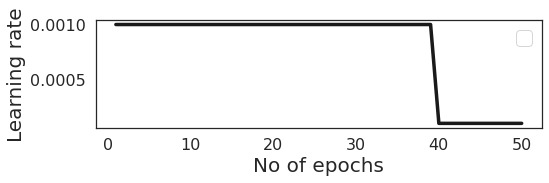

In [264]:
fig = plt.figure(figsize=(8,2))
plt.plot(epoch, learn_rate, linewidth=3.5,color='k')
#plt.set_xlim([0.00005 0.001])
plt.xlabel('No of epochs', fontsize = 20)
plt.ylabel('Learning rate', fontsize = 20)
plt.legend(fontsize=20)
plt.show()
fig.savefig('learning_rate.png')